In [1]:
import PIL
import gc
import torch
import torchvision
import os

import numpy as np
import matplotlib.pyplot as plt  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import Subset
from IPython.core.display import display, HTML
from numpy.random import RandomState
from wide_resnet import WideResNet
from auto_augment import AutoAugment, Cutout
from efficientnet_pytorch import EfficientNet
from cifar_loader import SmallSampleController
import torchvision.models as models


# display(HTML("<style>.container { width:40% !important; }</style>"))


In [2]:

def getAcc(preds,targets):
    return np.sum([1 if preds[i] == targets[i] else 0 for i in range(len(preds))])/len(preds)

def train(model, device, train_loader, optimizer, epoch, display=True):
    """
    Summary: Implements the training procedure for a given model
    == params ==
    model: the model to test
    device: cuda or cpu 
    optimizer: the optimizer for our training
    train_loader: dataloader for our train data
    display: output flag
    == output ==
    the mean train loss, the train accuracy
    """
    
    lossTracker = []
    
    targets=[]
    preds=[]
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        lossTracker.append(loss.detach())
        with torch.no_grad():
            pred = torch.argmax(output,1).cpu().numpy()

            preds.extend(pred)
            targets.extend(target.cpu().numpy())
        
    lossTracker = [x.item() for x in lossTracker]
    meanLoss = np.mean(lossTracker)
    accuracy = getAcc(preds,targets)
    if display:
        print('Train Epoch: {} [acc: {:.0f}%]\tLoss: {:.6f}'.format(
          epoch, 100. * accuracy, meanLoss))
        
    return accuracy, meanLoss



def test(model, device, test_loader,verbose=True):
    """
    Summary: Implements the testing procedure for a given model
    == params ==
    model: the model to test
    device: cuda or cpu 
    test_loader: dataloader for our test data
    verbose: output flag
    == output ==
    the mean test loss, the test accuracy
    """
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    meanLoss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if verbose: print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        mean_test_loss, correct, len(test_loader.dataset),
        accuracy))
        
    return accuracy, meanLoss


def checkTest(model,device,valSets,valTracker,latexTracker,epoch,
              model_name,optim_name,lr,totalTestSamples,seed,verbose=True):
    """
    Summary: checks the test accuracy, prints, and saves statistics
    """
    tempAcc = []
    tempLoss = []
    for val_loader in valSets:
        acc,loss = test(model, device, val_loader,verbose = False)
        tempAcc.append(acc)
        tempLoss.append(loss)
        
    meanAcc = np.mean(tempAcc)
    stdAcc = np.std(tempAcc)
    
    meanLoss = np.mean(tempLoss)
    if verbose:
        print('[Trained for {} epochs and tested on {} sets of 2000 images]\
        Avg Acc: {:.2f} +- {:.2f} , Avg Loss: {:.2f}'.format(
            epoch,VALIDATION_SET_NUM,meanAcc,stdAcc,meanLoss))
        
        
    tableRow = getLatexRow(architecture=model_name,epoch=epoch,accuracy=meanAcc,optim=optim_name,
                           lr=lr,totalTestSamples=totalTestSamples,dataAug="Nothing",
                           seed=seed,title=False)
    
    latexTracker.append(tableRow)
        
    valTracker["allLoss"].extend(tempLoss)
    valTracker["allAcc"].extend(tempAcc)
    valTracker["meanLoss"].append(meanLoss)
    valTracker["meanAcc"].append(meanAcc)
    valTracker["stdAcc"].append(stdAcc)





In [3]:
def getLatexRow(architecture,epoch,accuracy,optim,lr,
                totalTestSamples,dataAug,seed,title=False):
    """
    Summary: generates one row of latex for a results table
    """
    categories = ["Model","Epoch","Accuracy","Optimizer","lr","Test Sample Num",
                  "data augmentation","seed"]
    row = [str(architecture),str(epoch),str(round(accuracy,3)),str(optim),
           str(lr),str(totalTestSamples),str(dataAug),str(seed)]
    
    if title:
        c = "&".join(categories)
        r = "&".join(row)
        return "{}\\\\\n{}\\\\".format(c,r)
    else:
        r = "&".join(row)
        return "{}\\\\".format(r)
    
    
def plot(xlist,ylist,xlab,ylab,title,color,label,savedir=".",save=False):
    """
    Summary: plots the given list of numbers against its idices and 
    allows for high resolution saving
    """
    fig = plt.figure()
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.plot(xlist,ylist,color=color,marker=".",label=label)
    plt.legend()
    
    if save:
        if not os.path.isdir(savedir):
            os.mkdir(savedir)
        filepath = os.path.join(savedir,"{}".format(title))
        plt.savefig(filepath+".pdf")
        os.system("pdftoppm -png -r 300 {}.pdf {}.png".format(filepath,filepath))
        
    plt.show()
    
    

In [4]:
def getModel(model_name):
    if "wide" in model_name.lower():
        return WideResNet(28, 10, num_classes=10)
    elif "efficient" in model_name.lower():
        return EfficientNet.from_pretrained(model_name,num_classes = 10) # change to not be pretrained
    elif "vgg16" in model_name.lower():
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, 10)
        return model
    elif "alexnet" in model_name.lower():
        model = models.alexnet(pretrained=True)
        model.classifier = nn.Linear(256 * 6 * 6, 100)
        return model
    elif "resnet18" in model_name.lower():
        model = models.resnet18(pretrained=True)
#         model.fc.out_features = 10
        return model
    elif "resnet50" in model_name.lower():
        model = models.resnet50(pretrained=True)
#         model.fc.out_features = 10
        return model
    elif "densenet161" in model_name.lower():
        model = models.densenet161(pretrained=True)
#         model.fc.out_features = 10
        return model
    elif "wideresnet" in model_name.lower():
            model = models.wide_resnet50_2(pretrained=True)
    #         model.fc.out_features = 10
            return model
    elif "resnext101" in model_name.lower():
            model = models.resnext101_32x8d(pretrained=True)
    #         model.fc.out_features = 10
            return model
    elif "inception_v3" in model_name.lower():
            model = models.inception_v3(pretrained=True,aux_logits=False)
    #         model.fc.out_features = 10
            return model
    t
    
    
def getOptimizer128(optimizer_name,parameters):
    if "sgd" in  optimizer_name.lower():
        LR = 0.01
        optim = torch.optim.SGD(parameters, 
                                  lr=LR, momentum=0.9,
                                  weight_decay=0.0005)
        return optim, LR
    elif "adam" in optimizer_name.lower():
        LR = 0.00005
        optim = torch.optim.Adam(parameters, 
                              lr=LR, weight_decay=0)
        return optim, LR
        
    

In [5]:
class featureExtractor(nn.Module):
    def __init__(self,efficientNet):
        super().__init__()
        self.eNet = efficientNet 
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self.eNet._global_params.dropout_rate)
        self._fc = nn.Linear(2560,10)
        
        
    def forward(self,inputs):
        x = self.eNet.extract_features(inputs)
        x = x.flatten(start_dim=1)
        x = self._dropout(x)
        x = self._fc(x)
        return x

In [6]:
torch.cuda.empty_cache()
gc.collect()

#     resnet18 = models.resnet18()
#     alexnet = models.alexnet()
#     vgg16 = models.vgg16()
#     squeezenet = models.squeezenet1_0()
#     densenet = models.densenet161()
#     inception = models.inception_v3()
#     googlenet = models.googlenet()
#     shufflenet = models.shufflenet_v2_x1_0()
#     mobilenet = models.mobilenet_v2()
#     resnext50_32x4d = models.resnext50_32x4d()
#     wide_resnet50_2 = models.wide_resnet50_2()
#     mnasnet = models.mnasnet1_0()

OPTIM = "sgd"
MODEL = "vgg16"
EPOCH_NUM = 300
TRAIN_SAMPLE_NUM = 100
VAL_SAMPLE_NUM = 2000
BATCH_SIZE = 128
VALIDATION_SET_NUM = 1 
AUGMENT = True
VAL_DISPLAY_DIVISOR = 10
CIFAR_TRAIN = False
SEED = 1620017687
#687
#cifar-10:
#mean = (0.4914, 0.4822, 0.4465)
#std = (0.247, 0.243, 0.261)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
if AUGMENT:
    dataAugmentation = [ 
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        AutoAugment(),
        Cutout()
    ]
    augment = "Crop,Flip,AutoAugment,Cutout"
else: 
    dataAugmentation = []
    augment = "Nothing"


# We resize images to allow using imagenet pre-trained models, is there a better way?
resize = transforms.Resize(224) 

transform_train = transforms.Compose(dataAugmentation + [resize, transforms.ToTensor(), normalize]) 
transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same

cifar_train = datasets.CIFAR10(root='.',train=CIFAR_TRAIN, transform=transform_train, download=True)
cifar_val = datasets.CIFAR10(root='.',train=CIFAR_TRAIN, transform=transform_val, download=True)

ss = SmallSampleController(numClasses=10,trainSampleNum=TRAIN_SAMPLE_NUM, # abstract the data-loading procedure
                           valSampleNum=VAL_SAMPLE_NUM, batchSize=BATCH_SIZE, 
                           multiplier=VALIDATION_SET_NUM, trainDataset=cifar_train, 
                           valDataset=cifar_val)
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("here")
train_data, valSets, seed = ss.generateNewSet(device,valMultiplier = VALIDATION_SET_NUM,seed=SEED) #Sample from datasets
print("here")


eNet = getModel(MODEL).cuda()

# for param in eNet.parameters():
#     param.requires_grad = False
    
# model = featureExtractor(eNet).cuda()
model = eNet

# model.fc.out_features = 10

print(model.parameters)

parameters = list(model.features[28:].parameters()) +  list(model.classifier.parameters())
    
optimizer,LR = getOptimizer128(OPTIM, parameters)

# print(model.features[28:].parameters() + model.classifier.parameters())
print(' => Total trainable parameters: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))        

trainTracker = {"meanLoss":[],"accuracy":[]}
valTracker = {"allLoss":[],"allAcc":[],"meanLoss":[],"meanAcc":[],"stdAcc":[]}
latexTracker = []

print("Begin Train for {} epochs".format(EPOCH_NUM))
for epoch in range(EPOCH_NUM):
    acc, loss = train(model, device, train_data[0], optimizer, epoch+1, display=True)
    trainTracker["meanLoss"].append(loss)
    trainTracker["accuracy"].append(acc)
    
    if (epoch+1) % VAL_DISPLAY_DIVISOR == 0 or epoch==0:
        checkTest(model,device,valSets,valTracker,latexTracker,epoch+1,
              model_name=MODEL,optim_name=OPTIM,lr=LR,totalTestSamples=VAL_SAMPLE_NUM*VALIDATION_SET_NUM,
                  seed=seed,verbose=True)
        
          
# print(parameters)
        

Files already downloaded and verified
Files already downloaded and verified
here
Generated new permutation of the CIFAR train dataset with                 seed:1620017687, train sample num: 100, test sample num: 2000
here
<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 2

/home/benjamin/venv/torch11/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Trained for 1 epochs and tested on 1 sets of 2000 images]        Avg Acc: 13.05 +- 0.00 , Avg Loss: 2.26
Train Epoch: 2 [acc: 16%]	Loss: 2.305600
Train Epoch: 3 [acc: 19%]	Loss: 2.268693
Train Epoch: 4 [acc: 27%]	Loss: 2.099685
Train Epoch: 5 [acc: 34%]	Loss: 1.946564
Train Epoch: 6 [acc: 50%]	Loss: 1.805221
Train Epoch: 7 [acc: 45%]	Loss: 1.717084
Train Epoch: 8 [acc: 50%]	Loss: 1.625421
Train Epoch: 9 [acc: 55%]	Loss: 1.406245
Train Epoch: 10 [acc: 58%]	Loss: 1.361674
[Trained for 10 epochs and tested on 1 sets of 2000 images]        Avg Acc: 52.60 +- 0.00 , Avg Loss: 1.36
Train Epoch: 11 [acc: 59%]	Loss: 1.264124
Train Epoch: 12 [acc: 62%]	Loss: 1.185300
Train Epoch: 13 [acc: 60%]	Loss: 1.173583
Train Epoch: 14 [acc: 66%]	Loss: 1.194060
Train Epoch: 15 [acc: 61%]	Loss: 1.077284
Train Epoch: 16 [acc: 66%]	Loss: 1.051421
Train Epoch: 17 [acc: 76%]	Loss: 0.739313
Train Epoch: 18 [acc: 72%]	Loss: 0.854353
Train Epoch: 19 [acc: 72%]	Loss: 0.848363
Train Epoch: 20 [acc: 68%]	Loss: 0.9741

Train Epoch: 156 [acc: 95%]	Loss: 0.161424
Train Epoch: 157 [acc: 94%]	Loss: 0.131667
Train Epoch: 158 [acc: 95%]	Loss: 0.122916
Train Epoch: 159 [acc: 96%]	Loss: 0.072249
Train Epoch: 160 [acc: 92%]	Loss: 0.270656
[Trained for 160 epochs and tested on 1 sets of 2000 images]        Avg Acc: 63.85 +- 0.00 , Avg Loss: 1.75
Train Epoch: 161 [acc: 98%]	Loss: 0.100911
Train Epoch: 162 [acc: 97%]	Loss: 0.112137
Train Epoch: 163 [acc: 92%]	Loss: 0.201214
Train Epoch: 164 [acc: 97%]	Loss: 0.096156
Train Epoch: 165 [acc: 98%]	Loss: 0.082297
Train Epoch: 166 [acc: 95%]	Loss: 0.157904
Train Epoch: 167 [acc: 98%]	Loss: 0.108966
Train Epoch: 168 [acc: 98%]	Loss: 0.108602
Train Epoch: 169 [acc: 96%]	Loss: 0.101485
Train Epoch: 170 [acc: 96%]	Loss: 0.127841
[Trained for 170 epochs and tested on 1 sets of 2000 images]        Avg Acc: 61.55 +- 0.00 , Avg Loss: 1.92
Train Epoch: 171 [acc: 98%]	Loss: 0.073806
Train Epoch: 172 [acc: 96%]	Loss: 0.064220
Train Epoch: 173 [acc: 99%]	Loss: 0.067542
Train Epoc

In [7]:
dirname = latexTracker[-1][:-2] 

def writeTex(latexTracker,dirname):
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
        
    f= open(os.path.join(dirname,"latexTable.txt"),"w")
    for x in latexTracker:
        f.write(x+"\n")
    f.close()

writeTex(latexTracker,dirname)

for x in latexTracker:
    print(x)

vgg16&1&13.05&sgd&0.01&2000&Nothing&1620017687\\
vgg16&10&52.6&sgd&0.01&2000&Nothing&1620017687\\
vgg16&20&59.15&sgd&0.01&2000&Nothing&1620017687\\
vgg16&30&60.55&sgd&0.01&2000&Nothing&1620017687\\
vgg16&40&62.7&sgd&0.01&2000&Nothing&1620017687\\
vgg16&50&63.15&sgd&0.01&2000&Nothing&1620017687\\
vgg16&60&62.7&sgd&0.01&2000&Nothing&1620017687\\
vgg16&70&60.0&sgd&0.01&2000&Nothing&1620017687\\
vgg16&80&62.85&sgd&0.01&2000&Nothing&1620017687\\
vgg16&90&62.65&sgd&0.01&2000&Nothing&1620017687\\
vgg16&100&64.45&sgd&0.01&2000&Nothing&1620017687\\
vgg16&110&62.7&sgd&0.01&2000&Nothing&1620017687\\
vgg16&120&60.75&sgd&0.01&2000&Nothing&1620017687\\
vgg16&130&62.7&sgd&0.01&2000&Nothing&1620017687\\
vgg16&140&60.6&sgd&0.01&2000&Nothing&1620017687\\
vgg16&150&61.15&sgd&0.01&2000&Nothing&1620017687\\
vgg16&160&63.85&sgd&0.01&2000&Nothing&1620017687\\
vgg16&170&61.55&sgd&0.01&2000&Nothing&1620017687\\
vgg16&180&62.0&sgd&0.01&2000&Nothing&1620017687\\
vgg16&190&62.65&sgd&0.01&2000&Nothing&1620017687\\

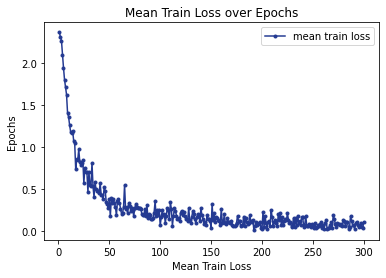

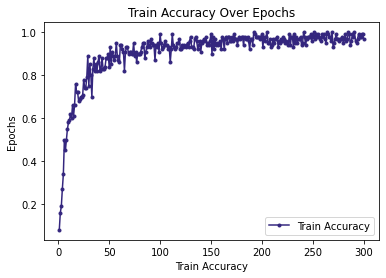

In [8]:

epochList = [x+1 for x in range(len(trainTracker["meanLoss"]))]

plot(xlist=epochList,ylist=trainTracker["meanLoss"],xlab="Mean Train Loss",
    ylab="Epochs",title="Mean Train Loss over Epochs",
    color="#243A92",label="mean train loss",savedir=dirname,save=True)

plot(xlist=epochList,ylist=trainTracker["accuracy"],xlab="Train Accuracy",
    ylab="Epochs",title="Train Accuracy Over Epochs",
    color="#34267E",label="Train Accuracy",savedir=dirname,save=True)

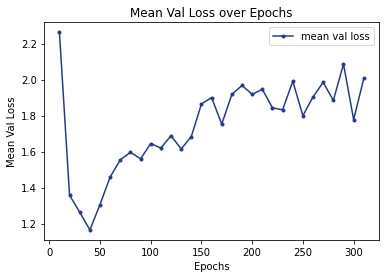

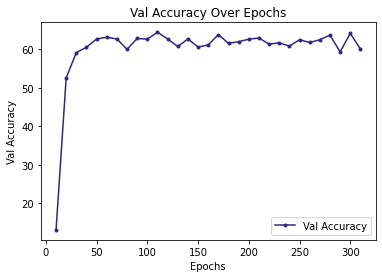

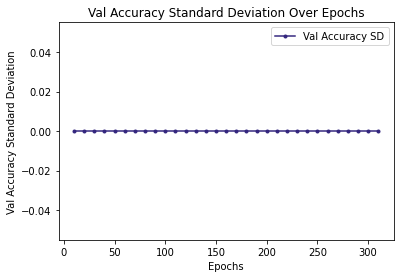

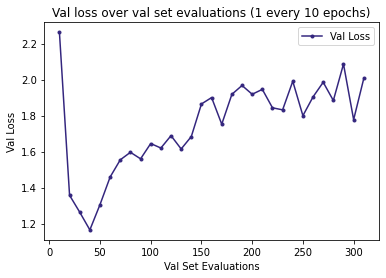

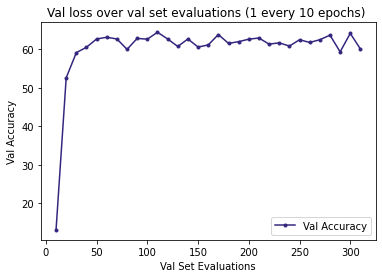

In [9]:

epochList = [VAL_DISPLAY_DIVISOR*(x+1) for x in range(len(valTracker["meanLoss"]))]

plot(xlist=epochList,ylist=valTracker["meanLoss"],xlab="Epochs",
    ylab="Mean Val Loss",title="Mean Val Loss over Epochs",
    color="#243A92",label="mean val loss",savedir=dirname,save=True)

plot(xlist=epochList,ylist=valTracker["meanAcc"],xlab="Epochs",
    ylab="Val Accuracy",title="Val Accuracy Over Epochs",
    color="#34267E",label="Val Accuracy",savedir=dirname,save=True)

plot(xlist=epochList,ylist=valTracker["stdAcc"],xlab="Epochs",
    ylab="Val Accuracy Standard Deviation",title="Val Accuracy Standard Deviation Over Epochs",
    color="#34267E",label="Val Accuracy SD",savedir=dirname,save=True)


valSetEvalCount = VAL_DISPLAY_DIVISOR * EPOCH_NUM * VALIDATION_SET_NUM
epochList = [VAL_DISPLAY_DIVISOR*(x+1) for x in range(len(valTracker["meanLoss"]))\
             for y in range(VALIDATION_SET_NUM)]


plot(xlist=epochList,ylist=valTracker["allLoss"],xlab="Val Set Evaluations",
    ylab="Val Loss",title="Val loss over val set evaluations ({} \
every {} epochs)".format(VALIDATION_SET_NUM,VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Loss",savedir=dirname,save=True)

plot(xlist=epochList,ylist=valTracker["allAcc"],xlab="Val Set Evaluations",
    ylab="Val Accuracy",title="Val loss over val set evaluations ({} \
every {} epochs) ".format(VALIDATION_SET_NUM,VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Accuracy",savedir=dirname,save=True)